<a href="https://colab.research.google.com/github/mhdSharuk/Kaggle-Ion-Switching/blob/master/Ion_Switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from collections import Counter
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
import lightgbm as lgb
from tqdm import tqdm_notebook
import gc
import warnings 
warnings.filterwarnings('ignore')

In [0]:
os.chdir('./drive/My Drive/Ion Switching')
os.listdir()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
def lgb_Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = metrics.cohen_kappa_score(labels, preds, weights = 'quadratic')
    return ('KaggleMetric', score, True)

In [0]:
def get_features(df):
    df.sort_values(by=['time'],inplace=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = (df.index - (df.batch * 50_000))
    df['batch_slices'] = df['batch_index'] // 5_000
    df['batch_slices2'] = df['batch'].astype(int).astype(str) + '_' + df['batch_slices'].astype(int).astype(str)

    df['rolling_signal_mean'] = df['signal'].rolling(10,min_periods=1).mean()
    df['rolling_signal_median'] = df['signal'].rolling(10,min_periods=1).median()

    for x in tqdm_notebook(['batch','batch_slices2']):
      sig_mean = df.groupby(x)['signal'].mean().to_dict()
      sig_median = df.groupby(x)['signal'].median().to_dict()
      sig_std = df.groupby(x)['signal'].std().to_dict()
      sig_max = df.groupby(x)['signal'].max().to_dict()
      sig_min = df.groupby(x)['signal'].min().to_dict()
      sig_mean_abs_diff = df.groupby(x)['signal'].apply(lambda x: np.mean(np.absolute(np.diff(x)))).to_dict()


      df[f'{x}_sig_mean'] =  df[x].map(sig_mean)
      df[f'{x}_sig_median'] =  df[x].map(sig_median)
      df[f'{x}_sig_std'] = df[x].map(sig_std)
      df[f'{x}_sig_max'] =  df[x].map(sig_max)
      df[f'{x}_sig_min'] =  df[x].map(sig_min)
      df[f'{x}_sig_abs_max'] = 0 - df[f'{x}_sig_min']
      df[f'{x}_sig_abs_min'] = 0 - df[f'{x}_sig_max']
      df[f'{x}_sig_mean_abs_diff'] = df[x].map(sig_mean_abs_diff)
      df[f'{x}_range'] = df[f'{x}_sig_max'] - df[f'{x}_sig_min']
      df[f'{x}_max_by_min'] = df[f'{x}_sig_max'] / df[f'{x}_sig_min']
      df[f'{x}_abs_min_max_avg'] = (df[f'{x}_sig_abs_max'] + df[f'{x}_sig_abs_min'])/2.0
      df[f'{x}_min_max_avg'] = (df[f'{x}_sig_max'] + df[f'{x}_sig_min'])/2.0
      df[f'{x}_sig_shift_pos'] = df.groupby(x)['signal'].shift()
      df[f'{x}_sig_shift_neg'] = df.groupby(x)['signal'].shift(-1)

    df['signal_shift_pos'] = df['signal'].shift()
    df['signal_shift_neg'] = df['signal'].shift(-1)

    for c in [c for c in df.columns if c not in ['time','signal','open_channels','batch_index','batch','batch_slices2','batch_slices']]:
      df[f'{c}_msignal'] = df[c] - df['signal']
    return df

In [0]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
sub = pd.read_csv('sample_submission.csv.zip')

In [8]:
train = get_features(train)
gc.collect()
test = get_features(test)
gc.collect()

0

0

In [9]:
train.head()
test.head()

,time,signal,open_channels,batch,batch_index,batch_slices,batch_slices2,rolling_signal_mean,rolling_signal_median,batch_sig_mean,batch_sig_median,batch_sig_std,batch_sig_max,batch_sig_min,batch_sig_abs_max,batch_sig_abs_min,batch_sig_mean_abs_diff,batch_range,batch_max_by_min,batch_abs_min_max_avg,batch_min_max_avg,batch_sig_shift_pos,batch_sig_shift_neg,batch_slices2_sig_mean,batch_slices2_sig_median,batch_slices2_sig_std,batch_slices2_sig_max,batch_slices2_sig_min,batch_slices2_sig_abs_max,batch_slices2_sig_abs_min,batch_slices2_sig_mean_abs_diff,batch_slices2_range,batch_slices2_max_by_min,batch_slices2_abs_min_max_avg,batch_slices2_min_max_avg,batch_slices2_sig_shift_pos,batch_slices2_sig_shift_neg,signal_shift_pos,signal_shift_neg,rolling_signal_mean_msignal,rolling_signal_median_msignal,batch_sig_mean_msignal,batch_sig_median_msignal,batch_sig_std_msignal,batch_sig_max_msignal,batch_sig_min_msignal,batch_sig_abs_max_msignal,batch_sig_abs_min_msignal,batch_sig_mean_abs_diff_msignal,batch_range_msignal,batch_max_by_min_msignal,batch_abs_min_max_avg_msignal,batch_min_max_avg_msignal,batch_sig_shift_pos_msignal,batch_sig_shift_neg_msignal,batch_slices2_sig_mean_msignal,batch_slices2_sig_median_msignal,batch_slices2_sig_std_msignal,batch_slices2_sig_max_msignal,batch_slices2_sig_min_msignal,batch_slices2_sig_abs_max_msignal,batch_slices2_sig_abs_min_msignal,batch_slices2_sig_mean_abs_diff_msignal,batch_slices2_range_msignal,batch_slices2_max_by_min_msignal,batch_slices2_abs_min_max_avg_msignal,batch_slices2_min_max_avg_msignal,batch_slices2_sig_shift_pos_msignal,batch_slices2_sig_shift_neg_msignal,signal_shift_pos_msignal,signal_shift_neg_msignal
0.0,0.0001,-2.7600,0,0.0,0.0,0.0,0_0,-2.760000,-2.76000,-2.687195,-2.6926,0.260662,-0.7651,-3.6621,3.6621,0.7651,0.270291,2.897,0.208924,2.2136,-2.2136,NaN,-2.8557,-2.695613,-2.6944,0.242952,-1.8626,-3.5896,3.5896,1.8626,0.269729,1.727,0.518888,2.7261,-2.7261,NaN,-2.8557,NaN,-2.8557,0.000000,0.00000,0.072805,0.0674,3.020662,1.9949,-0.9021,6.4221,3.5251,3.030291,5.6570,2.968924,4.9736,0.5464,NaN,-0.0957,0.064387,0.0656,3.002952,0.8974,-0.8296,6.3496,4.6226,3.029729,4.4870,3.278888,5.4861,0.0339,NaN,-0.0957,NaN,-0.0957
1.0,0.0002,-2.8557,0,0.0,1.0,0.0,0_0,-2.807850,-2.80785,-2.687195,-2.6926,0.260662,-0.7651,-3.6621,3.6621,0.7651,0.270291,2.897,0.208924,2.2136,-2.2136,-2.7600,-2.4074,-2.695613,-2.6944,0.242952,-1.8626,-3.5896,3.5896,1.8626,0.269729,1.727,0.518888,2.7261,-2.7261,-2.7600,-2.4074,-2.7600,-2.4074,0.047850,0.04785,0.168505,0.1631,3.116362,2.0906,-0.8064,6.5178,3.6208,3.125991,5.7527,3.064624,5.0693,0.6421,0.0957,0.4483,0.160087,0.1613,3.098652,0.9931,-0.7339,6.4453,4.7183,3.125429,4.5827,3.374588,5.5818,0.1296,0.0957,0.4483,0.0957,0.4483
2.0,0.0003,-2.4074,0,0.0,2.0,0.0,0_0,-2.674367,-2.76000,-2.687195,-2.6926,0.260662,-0.7651,-3.6621,3.6621,0.7651,0.270291,2.897,0.208924,2.2136,-2.2136,-2.8557,-3.1404,-2.695613,-2.6944,0.242952,-1.8626,-3.5896,3.5896,1.8626,0.269729,1.727,0.518888,2.7261,-2.7261,-2.8557,-3.1404,-2.8557,-3.1404,-0.266967,-0.35260,-0.279795,-0.2852,2.668062,1.6423,-1.2547,6.0695,3.1725,2.677691,5.3044,2.616324,4.6210,0.1938,-0.4483,-0.7330,-0.288213,-0.2870,2.650352,0.5448,-1.1822,5.9970,4.2700,2.677129,4.1344,2.926288,5.1335,-0.3187,-0.4483,-0.7330,-0.4483,-0.7330
3.0,0.0004,-3.1404,0,0.0,3.0,0.0,0_0,-2.790875,-2.80785,-2.687195,-2.6926,0.260662,-0.7651,-3.6621,3.6621,0.7651,0.270291,2.897,0.208924,2.2136,-2.2136,-2.4074,-3.1525,-2.695613,-2.6944,0.242952,-1.8626,-3.5896,3.5896,1.8626,0.269729,1.727,0.518888,2.7261,-2.7261,-2.4074,-3.1525,-2.4074,-3.1525,0.349525,0.33255,0.453205,0.4478,3.401062,2.3753,-0.5217,6.8025,3.9055,3.410691,6.0374,3.349324,5.3540,0.9268,0.7330,-0.0121,0.444787,0.4460,3.383352,1.2778,-0.4492,6.7300,5.0030,3.410129,4.8674,3.659288,5.8665,0.4143,0.7330,-0.0121,0.7330,-0.0121
4.0,0.0005,-3.1525,0,0.0,4.0,0.0,0_0,-2.863200,-2.85570,-2.687195,-2.6926,0.260662,-0.7651,-3.6621,3.6621,0.7651,0.270291,2.897,0.208924,2.2136,-2.2136,-3.1404,-2

,time,signal,batch,batch_index,batch_slices,batch_slices2,rolling_signal_mean,rolling_signal_median,batch_sig_mean,batch_sig_median,batch_sig_std,batch_sig_max,batch_sig_min,batch_sig_abs_max,batch_sig_abs_min,batch_sig_mean_abs_diff,batch_range,batch_max_by_min,batch_abs_min_max_avg,batch_min_max_avg,batch_sig_shift_pos,batch_sig_shift_neg,batch_slices2_sig_mean,batch_slices2_sig_median,batch_slices2_sig_std,batch_slices2_sig_max,batch_slices2_sig_min,batch_slices2_sig_abs_max,batch_slices2_sig_abs_min,batch_slices2_sig_mean_abs_diff,batch_slices2_range,batch_slices2_max_by_min,batch_slices2_abs_min_max_avg,batch_slices2_min_max_avg,batch_slices2_sig_shift_pos,batch_slices2_sig_shift_neg,signal_shift_pos,signal_shift_neg,rolling_signal_mean_msignal,rolling_signal_median_msignal,batch_sig_mean_msignal,batch_sig_median_msignal,batch_sig_std_msignal,batch_sig_max_msignal,batch_sig_min_msignal,batch_sig_abs_max_msignal,batch_sig_abs_min_msignal,batch_sig_mean_abs_diff_msignal,batch_range_msignal,batch_max_by_min_msignal,batch_abs_min_max_avg_msignal,batch_min_max_avg_msignal,batch_sig_shift_pos_msignal,batch_sig_shift_neg_msignal,batch_slices2_sig_mean_msignal,batch_slices2_sig_median_msignal,batch_slices2_sig_std_msignal,batch_slices2_sig_max_msignal,batch_slices2_sig_min_msignal,batch_slices2_sig_abs_max_msignal,batch_slices2_sig_abs_min_msignal,batch_slices2_sig_mean_abs_diff_msignal,batch_slices2_range_msignal,batch_slices2_max_by_min_msignal,batch_slices2_abs_min_max_avg_msignal,batch_slices2_min_max_avg_msignal,batch_slices2_sig_shift_pos_msignal,batch_slices2_sig_shift_neg_msignal,signal_shift_pos_msignal,signal_shift_neg_msignal
5000000.0,500.0001,-2.6498,100.0,0.0,0.0,100_0,-2.64980,-2.6498,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.6062,-0.6995,0.284248,4.3057,-0.193971,1.45335,-1.45335,NaN,-2.8494,-2.61659,-2.61655,0.248855,-1.7291,-3.3988,3.3988,1.7291,0.270729,1.6697,0.508738,2.56395,-2.56395,NaN,-2.8494,NaN,-2.8494,0.00000,0.0000,0.797097,0.7602,3.245554,3.3493,-0.9564,6.2560,1.9503,2.934048,6.9555,2.455829,4.10315,1.19645,NaN,-0.1996,0.03321,0.03325,2.898655,0.9207,-0.7490,6.0486,4.3789,2.920529,4.3195,3.158538,5.21375,0.08585,NaN,-0.1996,NaN,-0.1996
5000001.0,500.0002,-2.8494,100.0,1.0,0.0,100_0,-2.74960,-2.7496,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.6062,-0.6995,0.284248,4.3057,-0.193971,1.45335,-1.45335,-2.6498,-2.8600,-2.61659,-2.61655,0.248855,-1.7291,-3.3988,3.3988,1.7291,0.270729,1.6697,0.508738,2.56395,-2.56395,-2.6498,-2.8600,-2.6498,-2.8600,0.09980,0.0998,0.996697,0.9598,3.445154,3.5489,-0.7568,6.4556,2.1499,3.133648,7.1551,2.655429,4.30275,1.39605,0.1996,-0.0106,0.23281,0.23285,3.098255,1.1203,-0.5494,6.2482,4.5785,3.120129,4.5191,3.358138,5.41335,0.28545,0.1996,-0.0106,0.1996,-0.0106
5000002.0,500.0003,-2.8600,100.0,2.0,0.0,100_0,-2.78640,-2.8494,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.6062,-0.6995,0.284248,4.3057,-0.193971,1.45335,-1.45335,-2.8494,-2.4350,-2.61659,-2.61655,0.248855,-1.7291,-3.3988,3.3988,1.7291,0.270729,1.6697,0.508738,2.56395,-2.56395,-2.8494,-2.4350,-2.8494,-2.4350,0.07360,0.0106,1.007297,0.9704,3.455754,3.5595,-0.7462,6.4662,2.1605,3.144248,7.1657,2.666029,4.31335,1.40665,0.0106,0.4250,0.24341,0.24345,3.108855,1.1309,-0.5388,6.2588,4.5891,3.130729,4.5297,3.368738,5.42395,0.29605,0.0106,0.4250,0.0106,0.4250
5000003.0,500.0004,-2.4350,100.0,3.0,0.0,100_0,-2.69855,-2.7496,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.6062,-0.6995,0.284248,4.3057,-0.193971,1.45335,-1.45335,-2.8600,-2.6155,-2.61659,-2.61655,0.248855,-1.7291,-3.3988,3.3988,1.7291,0.270729,1.6697,0.508738,2.56395,-2.56395,-2.8600,-2.6155,-2.8600,-2.6155,-0.26355,-0.3146,0.582297,0.5454,3.030754,3.1345,-1.1712,6.0412,1.7355,2.719248,6.7407,2.241029,3.88835,0.98165,-0.4250,-0.1805,-0.18159,-0.18155,2.683855,0.7059,-0.9638,5.8338,4.1641,2.705729,4.1047,2.943738,4.99895,-0.12895,-0.4250,-0.1805,-0.4250,-0.1805
5000004.0,500.0005,-2.6155,100.0,4.0,0.0,100_0,-2.68194,-2.6498,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.60

In [0]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]
x_train, x_val, y_train, y_val = train_test_split(train[col], train['open_channels'], test_size=0.1, random_state=42)
del train

In [0]:
params = {'learning_rate': 0.08, 'max_depth': 7, 'num_leaves':2**7+1, 'metric': 'rmse', 'random_state': 7, 'n_jobs':-1} 

In [13]:
model = lgb.train(params, lgb.Dataset(x_train, y_train), 1000,  lgb.Dataset(x_val, y_val), verbose_eval=50, early_stopping_rounds=10, feval=lgb_Metric)
preds = model.predict(test[col], num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds.
[50]	valid_0's rmse: 0.180562	valid_0's KaggleMetric: 0.99712
[100]	valid_0's rmse: 0.167651	valid_0's KaggleMetric: 0.997409
[150]	valid_0's rmse: 0.165952	valid_0's KaggleMetric: 0.997466
Early stopping, best iteration is:
[156]	valid_0's rmse: 0.165787	valid_0's KaggleMetric: 0.99747


In [14]:
test['open_channels'] = np.round(np.clip(preds, 0, 10)).astype(int)
test['open_channels'].value_counts()
test[['time','open_channels']].to_csv('submission.csv', index=False, float_format='%.4f')

,time,signal,batch,batch_index,batch_slices,batch_slices2,rolling_signal_mean,rolling_signal_median,batch_sig_mean,batch_sig_median,batch_sig_std,batch_sig_max,batch_sig_min,batch_sig_abs_max,batch_sig_abs_min,batch_sig_mean_abs_diff,batch_range,batch_max_by_min,batch_abs_min_max_avg,batch_min_max_avg,batch_sig_shift_pos,batch_sig_shift_neg,batch_slices2_sig_mean,batch_slices2_sig_median,batch_slices2_sig_std,batch_slices2_sig_max,batch_slices2_sig_min,batch_slices2_sig_abs_max,batch_slices2_sig_abs_min,batch_slices2_sig_mean_abs_diff,batch_slices2_range,batch_slices2_max_by_min,batch_slices2_abs_min_max_avg,batch_slices2_min_max_avg,batch_slices2_sig_shift_pos,batch_slices2_sig_shift_neg,signal_shift_pos,signal_shift_neg,rolling_signal_mean_msignal,rolling_signal_median_msignal,batch_sig_mean_msignal,batch_sig_median_msignal,batch_sig_std_msignal,batch_sig_max_msignal,batch_sig_min_msignal,batch_sig_abs_max_msignal,batch_sig_abs_min_msignal,batch_sig_mean_abs_diff_msignal,batch_range_msignal,batch_max_by_min_msignal,batch_abs_min_max_avg_msignal,batch_min_max_avg_msignal,batch_sig_shift_pos_msignal,batch_sig_shift_neg_msignal,batch_slices2_sig_mean_msignal,batch_slices2_sig_median_msignal,batch_slices2_sig_std_msignal,batch_slices2_sig_max_msignal,batch_slices2_sig_min_msignal,batch_slices2_sig_abs_max_msignal,batch_slices2_sig_abs_min_msignal,batch_slices2_sig_mean_abs_diff_msignal,batch_slices2_range_msignal,batch_slices2_max_by_min_msignal,batch_slices2_abs_min_max_avg_msignal,batch_slices2_min_max_avg_msignal,batch_slices2_sig_shift_pos_msignal,batch_slices2_sig_shift_neg_msignal,signal_shift_pos_msignal,signal_shift_neg_msignal,open_channels
5000000.0,500.0001,-2.6498,100.0,0.0,0.0,100_0,-2.64980,-2.6498,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.6062,-0.6995,0.284248,4.3057,-0.193971,1.45335,-1.45335,NaN,-2.8494,-2.61659,-2.61655,0.248855,-1.7291,-3.3988,3.3988,1.7291,0.270729,1.6697,0.508738,2.56395,-2.56395,NaN,-2.8494,NaN,-2.8494,0.00000,0.0000,0.797097,0.7602,3.245554,3.3493,-0.9564,6.2560,1.9503,2.934048,6.9555,2.455829,4.10315,1.19645,NaN,-0.1996,0.03321,0.03325,2.898655,0.9207,-0.7490,6.0486,4.3789,2.920529,4.3195,3.158538,5.21375,0.08585,NaN,-0.1996,NaN,-0.1996,0
5000001.0,500.0002,-2.8494,100.0,1.0,0.0,100_0,-2.74960,-2.7496,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.6062,-0.6995,0.284248,4.3057,-0.193971,1.45335,-1.45335,-2.6498,-2.8600,-2.61659,-2.61655,0.248855,-1.7291,-3.3988,3.3988,1.7291,0.270729,1.6697,0.508738,2.56395,-2.56395,-2.6498,-2.8600,-2.6498,-2.8600,0.09980,0.0998,0.996697,0.9598,3.445154,3.5489,-0.7568,6.4556,2.1499,3.133648,7.1551,2.655429,4.30275,1.39605,0.1996,-0.0106,0.23281,0.23285,3.098255,1.1203,-0.5494,6.2482,4.5785,3.120129,4.5191,3.358138,5.41335,0.28545,0.1996,-0.0106,0.1996,-0.0106,0
5000002.0,500.0003,-2.8600,100.0,2.0,0.0,100_0,-2.78640,-2.8494,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.6062,-0.6995,0.284248,4.3057,-0.193971,1.45335,-1.45335,-2.8494,-2.4350,-2.61659,-2.61655,0.248855,-1.7291,-3.3988,3.3988,1.7291,0.270729,1.6697,0.508738,2.56395,-2.56395,-2.8494,-2.4350,-2.8494,-2.4350,0.07360,0.0106,1.007297,0.9704,3.455754,3.5595,-0.7462,6.4662,2.1605,3.144248,7.1657,2.666029,4.31335,1.40665,0.0106,0.4250,0.24341,0.24345,3.108855,1.1309,-0.5388,6.2588,4.5891,3.130729,4.5297,3.368738,5.42395,0.29605,0.0106,0.4250,0.0106,0.4250,0
5000003.0,500.0004,-2.4350,100.0,3.0,0.0,100_0,-2.69855,-2.7496,-1.852703,-1.8896,0.595754,0.6995,-3.6062,3.6062,-0.6995,0.284248,4.3057,-0.193971,1.45335,-1.45335,-2.8600,-2.6155,-2.61659,-2.61655,0.248855,-1.7291,-3.3988,3.3988,1.7291,0.270729,1.6697,0.508738,2.56395,-2.56395,-2.8600,-2.6155,-2.8600,-2.6155,-0.26355,-0.3146,0.582297,0.5454,3.030754,3.1345,-1.1712,6.0412,1.7355,2.719248,6.7407,2.241029,3.88835,0.98165,-0.4250,-0.1805,-0.18159,-0.18155,2.683855,0.7059,-0.9638,5.8338,4.1641,2.705729,4.1047,2.943738,4.99895,-0.12895,-0.4250,-0.1805,-0.4250,-0.1805,0
5000004.0,500.0005,-2.6155,100.0,4.0,0.0,100_0,-2.68194,-2.6498,-1.852703,-1.8896,0.5957

In [19]:
!kaggle competitions submit -c liverpool-ion-switching -f submission.csv -m "LGB 0.08"

100% 21.0M/21.0M [00:00<00:00, 47.1MB/s]
Successfully submitted to University of Liverpool - Ion Switching

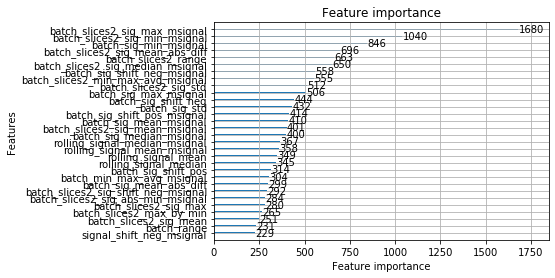

In [23]:
lgb.plot_importance(model,importance_type='split', max_num_features=30)

In [24]:
train['batch_slice2_sig_man_msignal'].head(100)

NameError: ignored